# Live Locked Shields

In [ ]:
configuration = "fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no"
dataset_path = "datasets"
model_path = "trained_models/fine_tune_all_years_ded_coa_med_seq-128_old_" + configuration + "/finetuned_model"

metadata_corpus = {}

# Methods

In [ ]:
import os

ip_documents = {}
def get_next_sentences(document_path):    
    file_list = os.listdir(document_path)
    ip1_list = []
    ip2_list = []
    sentence_list = []
    for file in file_list:
        with open(document_path + "/" + file, 'r') as f:
            ip1 = file.split(".txt")[0]
            if ip1 in ip_documents:
                position = ip_documents[ip1]["position"]
                f.seek(position)
                lines = f.readlines()
                ip_documents[ip1]["position"] = f.tell()
            else:
                lines = f.readlines()
                ip_documents[ip1] = {"position": f.tell()}
                        
            for line in lines:
                line.strip()
                ip2, start_time, end_time, sentence = line.split(",")
                ip1_list.append(ip1)
                ip2_list.append(ip2)
                sentence_list.append(sentence)
    return ip1_list, ip2_list, sentence_list

In [ ]:
import numpy as np

def update_embeddings(sentence_dataset, metadata_corpus, ip1_list, ip2_list, embeddings):

    changed_ip1_hosts = set()
    changed_ip2_hosts = set()
    
    for i, (ip1, ip2) in enumerate(zip(ip1_list, ip2_list)):
        emb_idx = sentence_dataset.original_index[i]
        embedding = embeddings[emb_idx]
        
        if ip1 not in metadata_corpus:
            metadata_corpus[ip1] = {
                "embedding" : embedding,
                "documents" : {
                    ip2 : embedding,
                },
                "counts" : {
                    ip2 : 1
                }
            }
            changed_ip1_hosts.add(ip1)
            changed_ip2_hosts.add(ip1 + "-" + ip2)

        else:
            if ip2 not in metadata_corpus[ip1]["documents"]:
                metadata_corpus[ip1]["documents"][ip2] = embedding
                metadata_corpus[ip1]["counts"][ip2] = 1
                
            else:
                n = metadata_corpus[ip1]["counts"][ip2]
                old_emb = metadata_corpus[ip1]["documents"][ip2]
                new_emb = (old_emb * n + embedding)
                metadata_corpus[ip1]["documents"][ip2] = new_emb / (n + 1)
                metadata_corpus[ip1]["counts"][ip2] = n + 1
                
            changed_ip2_hosts.add(ip1 + "-" + ip2)  
            changed_ip1_hosts.add(ip1)
                
            doc_emb = np.zeros(embedding.shape)
            for ip2 in metadata_corpus[ip1]["documents"]:
                doc_emb += metadata_corpus[ip1]["documents"][ip2]
            doc_emb /= len(metadata_corpus[ip1]["documents"])
            metadata_corpus[ip1]["embedding"] = doc_emb
         
        
    class_host_embeddings = []
    class_host_host_embeddings = []
    class_ip1 = []
    class_ip2 = [] 
    
    for ip1 in changed_ip1_hosts:
        class_ip1.append(ip1)
        class_host_embeddings.append(metadata_corpus[ip1]["embedding"])
    
    for ip1_ip2 in changed_ip2_hosts:
        ip1, ip2 = ip1_ip2.split("-")
        class_ip2.append((ip1, ip2))
        class_host_host_embeddings.append(metadata_corpus[ip1]["documents"][ip2])

    return class_host_embeddings, class_host_host_embeddings, class_ip1, class_ip2

In [ ]:
from similarity_dataset import *
def get_similarity_batch(embeddings, similarity_dataset, is_host_host=False, batch_size=512, top_k=5):

    batched_embeddings = [embeddings[i:i+batch_size] for i in range(0, len(embeddings), batch_size)]

    all_top_k_labels = []
    all_top_k_similarities = []

    from tqdm import tqdm
    for batch_embeddings in tqdm(batched_embeddings):
        
        if is_host_host:
            batch_top_k_labels, batch_top_k_similarities = similarity_dataset.get_host_host_cosine_similarity(batch_embeddings, top_k)
        else:
            batch_top_k_labels, batch_top_k_similarities = similarity_dataset.get_host_cosine_similarity(batch_embeddings, top_k)
        
        all_top_k_labels.extend(batch_top_k_labels)
        all_top_k_similarities.extend(batch_top_k_similarities)

    return np.array(all_top_k_labels), np.array(all_top_k_similarities)

In [ ]:
from ip_utils import *
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def get_top_k_similar_ips(search_ip, host_host_embeddings, host_embeddings, ip1_list, ip2_list, k=5):
    search_ip = expand_ipv6(search_ip)

    search_host_embeddings = []
    for i, ip in enumerate(ip1_list):
        if ip == search_ip:
            search_host_embeddings.append(host_embeddings[i])
    search_host_host_embeddings = []
    for i, (ip1, ip2) in enumerate(ip2_list):
        if ip1 == search_ip:
            search_host_host_embeddings.append(host_host_embeddings[i])
    if len(search_host_embeddings) == 0:
        print("No embeddings found for ip:", search_ip)
        return None, None
    
    search_host_host_embeddings = np.array(search_host_host_embeddings)
    search_host_embeddings = np.array(search_host_embeddings)
        
    host_similarities = cosine_similarity(search_host_embeddings, host_embeddings)
    top_k = np.argsort(-host_similarities, axis=1)[:, :k]
    top_k_labels = np.array([ip1_list[i] for i in top_k.flatten()]).reshape(top_k.shape)
    top_k_similarities = np.array([host_similarities[i][top_k[i]] for i in range(len(search_host_embeddings))])    

    host_host_similarities = cosine_similarity(search_host_host_embeddings, host_host_embeddings)
    top_k_host_host = np.argsort(-host_host_similarities, axis=1)[:, :k]
    top_k_host_host_labels = np.array([ip2_list[i][0] + "-" + ip2_list[i][1] for i in top_k_host_host.flatten()]).reshape(top_k_host_host.shape)
    top_k_host_host_similarities = np.array([host_host_similarities[i][top_k_host_host[i]] for i in range(len(search_host_host_embeddings))])
    
    # create two pandas dataframes that is sorted by score
    host_df = pd.DataFrame()
    host_df["ip"] = top_k_labels.flatten()
    host_df["score"] = top_k_similarities.flatten()
    host_df = host_df.sort_values(by="score", ascending=False)
    
    host_host_df = pd.DataFrame()
    host_host_df["hostpair"] = top_k_host_host_labels.flatten()
    host_host_df["score"] = top_k_host_host_similarities.flatten()
    host_host_df = host_host_df.sort_values(by="score", ascending=False)
    
    return host_df, host_host_df


In [ ]:
import joblib
host_model_path = "rf_host_model_22.pkl"
host_host_model_path = "rf_host_host_model_22.pkl"

clf_host = joblib.load(host_model_path)
clf_host_host = joblib.load(host_host_model_path)

# Capture

In [ ]:
from evaluate_bert import *
from similarity_dataset import SimilarityDataset
from bert_single_sentence_dataset import SingleSentenceDataset

metadata_corpus = {}
ip_documents = {}

ip1_list, ip2_list, sentence_list = get_next_sentences("ls24_live_dataset/phase_0")
sentence_dataset = SingleSentenceDataset(sentence_list)
embeddings = get_embeddings(model_path, sentence_dataset, batch_size=512, resample=False, use_labels=False)
host_embeddings, host_host_embeddings, ip1_list, ip2_list = update_embeddings(sentence_dataset, metadata_corpus, ip1_list, ip2_list, embeddings)

similarity_2022_dataset = SimilarityDataset(2022, fine=True, label_path="ip_labels_2022.txt", only_rt=False)
top_host_labels, top_host_simil = get_similarity_batch(host_embeddings, similarity_2022_dataset, is_host_host=False, batch_size=512, top_k=5)
top_host_host_labels, top_host_host_simil = get_similarity_batch(host_host_embeddings, similarity_2022_dataset, is_host_host=True, batch_size=64, top_k=5)

with open("alerts_host.txt", "a") as f:
    for i, (labels, similarities) in enumerate(zip(top_host_labels, top_host_simil)):
        if (labels == 2).sum() > 2:
            labels_str = ",".join(map(str, labels))
            similarities_str = ",".join(map(str, similarities))
            f.write(ip1_list[i] + "," + labels_str + "," + similarities_str + "\n")
            print(ip1_list[i], labels, similarities)
            
with open("alerts_host_host.txt", "a") as f:
    for i, (labels, similarities) in enumerate(zip(top_host_host_labels, top_host_host_simil)):
        # number of labels that are 2 is greater than 2
        if (labels == 2).sum() > 1:
            labels_str = ",".join(map(str, labels))
            similarities_str = ",".join(map(str, similarities))
            f.write(ip2_list[i][0] + "," + ip2_list[i][1] + "," + labels_str + "," + similarities_str + "\n")
            print(ip2_list[i], labels, similarities)
            
host_embeddings = np.array(host_embeddings)
host_host_embeddings = np.array(host_host_embeddings)
host_pred = clf_host.predict(host_embeddings)
host_host_pred = clf_host_host.predict(host_host_embeddings)

# if there is a prediction with 1, write ip to log file
if (host_pred == 1).sum() > 0:
    with open("alerts_host_rf.txt", "a") as f:
        for i, pred in enumerate(host_pred):
            if pred == 1:
                f.write(ip1_list[i] + "\n")
                print(ip1_list[i])
if (host_host_pred == 1).sum() > 0:
    with open("alerts_host_host_rf.txt", "a") as f:
        for i, pred in enumerate(host_host_pred):
            if pred == 1:
                f.write(ip2_list[i][0] + "," + ip2_list[i][1] + "\n")
                print(ip2_list[i])


# summary of classes predicted:
from collections import Counter
print(Counter(host_pred))
print(Counter(host_host_pred))

In [ ]:
for i, (labels, similarities) in enumerate(zip(top_host_host_labels, top_host_host_simil)):
    # number of labels that are 2 is greater than 2
    if (labels == 2).sum() > 1:
        labels_str = ",".join(map(str, labels))
        similarities_str = ",".join(map(str, similarities))
        print(ip2_list[i], labels, similarities)


# Semantic Similarity Search

In [62]:
host_res, host_host_res = get_top_k_similar_ips("109.62.69.183", host_host_embeddings, host_embeddings, ip1_list, ip2_list, k=10)

In [63]:
host_res

,ip,score
0,109.62.69.183,1.000000
1,186.190.232.131,0.925892
2,20.190.181.1,0.891966
3,216.58.211.232,0.873253
4,3.226.144.159,0.861486
5,2606:4700:3034:0:0:0:ac43:df69,0.860038
6,2606:4700:3032:0:0:0:ac43:a5a2,0.849403
7,2606:4700:3108:0:0:0:ac42:2908,0.834141
8,2600:9000:2368:b800:3:db06:4200:93a1,0.832340
9,2a01:111:f100:4002:0:0:9d37:c1c2,0.830086


In [64]:
host_host_res

,hostpair,score
0,109.62.69.183-100.99.7.5,1.000000
1,186.190.232.131-100.99.7.5,0.925892
2,2a05:d018:91c:3200:2846:99fb:81b6:1e11-2a07:1182:7:20:0:0:0:30,0.879625
3,3.226.144.159-10.7.12.32,0.861486
4,151.101.246.62-10.7.12.29,0.855646
5,104.18.38.76-10.7.13.14,0.854946
6,2a01:111:f100:a004:0:0:bfeb:8ad6-2a07:1182:7:12:0:0:0:3,0.847857
7,101.33.20.163-10.7.11.33,0.836719
8,91.228.167.170-10.7.11.7,0.835374
9,108.156.22.43-10.7.13.14,0.831642


# Labelling

In [77]:
# find all hosts with a host-host embedding that has very high similarity score for label 2
rt_hosts = []
for i, (labels, similarities) in enumerate(zip(top_host_host_labels, top_host_host_simil)):
    # number of labels that are 2 is greater than 2
    if labels[0] == 2 and similarities[0] > 0.95:
        rt_hosts.append(ip2_list[i][0])

rt_embeddings = [embedding for i, embedding in enumerate(host_embeddings) if ip1_list[i] in rt_hosts]
rt_host_host_embeddings = [embedding for i, embedding in enumerate(host_host_embeddings) if ip2_list[i][0] in rt_hosts]
bt_embeddings = [embedding for i, embedding in enumerate(host_embeddings) if ip1_list[i] not in rt_hosts]
bt_host_host_embeddings = [embedding for i, embedding in enumerate(host_host_embeddings) if ip2_list[i][0] not in rt_hosts]

# Visualizations

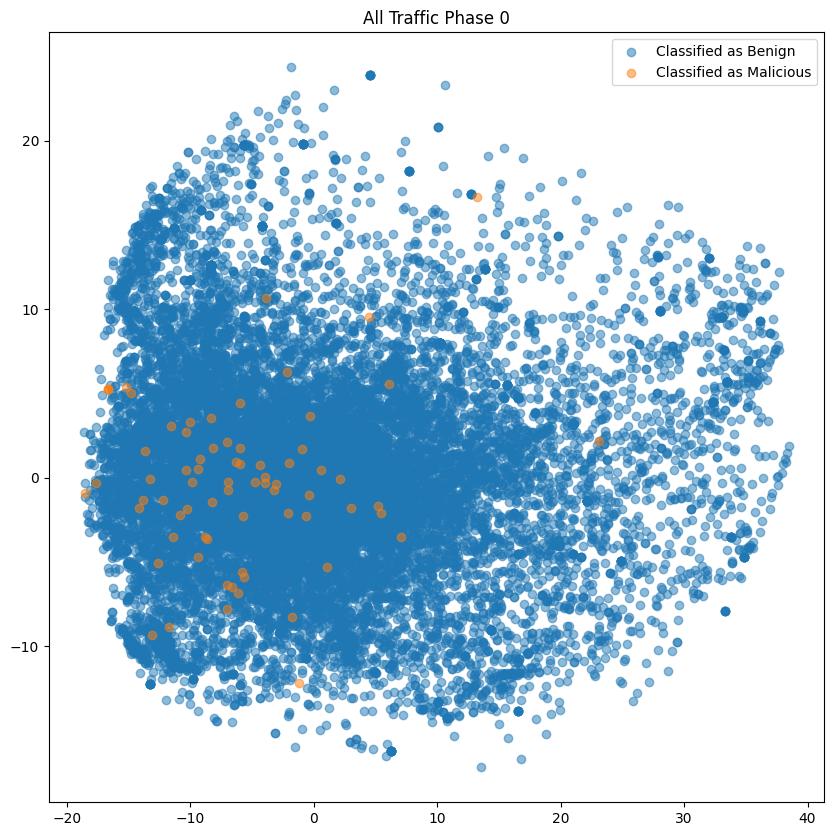

In [79]:
from evaluate_bert import *

visualize_embeddings([bt_host_host_embeddings, rt_host_host_embeddings], ["Classified as Benign", "Classified as Malicious"], "All Traffic Phase 0", "pca")

# Operational

In [ ]:
from bert_single_sentence_dataset import SingleSentenceDataset
import time

metadata_corpus = {}
ip_documents = {}

while True:
    time.sleep(1)
    
    ip1_list, ip2_list, sentence_list = get_next_sentences("ls24_live_dataset/phase_0")
    if len(sentence_list) == 0:
        continue
    
    sentence_dataset = SingleSentenceDataset(sentence_list)
    from evaluate_bert import *
    embeddings = get_embeddings(model_path, sentence_dataset, batch_size=512, resample=False, use_labels=False)
    host_embeddings, host_host_embeddings, ip1_list, ip2_list = update_embeddings(sentence_dataset, metadata_corpus, ip1_list, ip2_list, embeddings)
    from similarity_dataset import SimilarityDataset
    similarity_2022_dataset = SimilarityDataset(2022, fine=True, label_path="ip_labels_2022.txt", only_rt=False)
    top_host_labels, top_host_simil = get_similarity_batch(host_embeddings, similarity_2022_dataset, is_host_host=False, batch_size=512, top_k=5)
    top_host_host_labels, top_host_host_simil = get_similarity_batch(host_host_embeddings, similarity_2022_dataset, is_host_host=True, batch_size=64, top_k=5)

    with open("alerts_host.txt", "a") as f:
        for i, (labels, similarities) in enumerate(zip(top_host_labels, top_host_simil)):
            if (labels == 2).sum() > 2:
                labels_str = ",".join(map(str, labels))
                similarities_str = ",".join(map(str, similarities))
                f.write(ip1_list[i] + "," + labels_str + "," + similarities_str + "\n")
                print(ip1_list[i], labels, similarities)
                
    with open("alerts_host_host.txt", "a") as f:
        for i, (labels, similarities) in enumerate(zip(top_host_host_labels, top_host_host_simil)):
            # number of labels that are 2 is greater than 2
            if (labels == 2).sum() > 1:
                labels_str = ",".join(map(str, labels))
                similarities_str = ",".join(map(str, similarities))
                f.write(ip2_list[i][0] + "," + ip2_list[i][1] + "," + labels_str + "," + similarities_str + "\n")
                print(ip2_list[i], labels, similarities)
                
    host_embeddings = np.array(host_embeddings)
    host_host_embeddings = np.array(host_host_embeddings)
    host_pred = clf_host.predict(host_embeddings)
    host_host_pred = clf_host_host.predict(host_host_embeddings)

    # if there is a prediction with 1, write ip to log file
    if (host_pred == 1).sum() > 0:
        with open("alerts_host_rf.txt", "a") as f:
            for i, pred in enumerate(host_pred):
                if pred == 1:
                    f.write(ip1_list[i] + "\n")
                    print(ip1_list[i])
    if (host_host_pred == 1).sum() > 0:
        with open("alerts_host_host_rf.txt", "a") as f:
            for i, pred in enumerate(host_host_pred):
                if pred == 1:
                    f.write(ip2_list[i][0] + "," + ip2_list[i][1] + "\n")
                    print(ip2_list[i])
    
    
    # summary of classes predicted:
    from collections import Counter
    print(Counter(host_pred))
    print(Counter(host_host_pred))

# Random Forest Model

In [ ]:
host_embeddings = np.array(host_embeddings)
host_host_embeddings = np.array(host_host_embeddings)
host_pred = clf_host.predict(host_embeddings)
host_host_pred = clf_host_host.predict(host_host_embeddings)

# summary of classes predicted:
from collections import Counter
print(Counter(host_pred))
print(Counter(host_host_pred))

# Training Models

In [ ]:
from similarity_dataset import SimilarityDataset
data_2021 = SimilarityDataset(2021, fine=True, label_path="ip_labels_2021.txt", only_rt=False)
data_2022 = SimilarityDataset(2022, fine=True, label_path="ip_labels_2022.txt", only_rt=False)

In [ ]:
import numpy as np

X_rt_21, X_rt_ip_21 = data_2021.get_rt_host_embeddings()
X_b_21, X_b_ip_21 = data_2021.get_benign_host_embeddings()
X_rt_22, X_rt_ip_22 = data_2022.get_rt_host_embeddings()
X_b_22, X_b_ip_22 = data_2022.get_benign_host_embeddings()
XX_rt_21, XX_rt_ip_21 = data_2021.get_rt_host_host_embeddings()
XX_b_21, XX_b_ip_21 = data_2021.get_benign_host_host_embeddings()
XX_rt_22, XX_rt_ip_22 = data_2022.get_rt_host_host_embeddings()
XX_b_22, XX_b_ip_22 = data_2022.get_benign_host_host_embeddings()

X_21 = np.concatenate([X_rt_21, X_b_21])
y_21 = np.concatenate([np.ones(X_rt_21.shape[0]), np.zeros(X_b_21.shape[0])])
X_22 = np.concatenate([X_rt_22, X_b_22])
y_22 = np.concatenate([np.ones(X_rt_22.shape[0]), np.zeros(X_b_22.shape[0])])
XX_21 = np.concatenate([XX_rt_21, XX_b_21])
yy_21 = np.concatenate([np.ones(XX_rt_21.shape[0]), np.zeros(XX_b_21.shape[0])])
XX_22 = np.concatenate([XX_rt_22, XX_b_22])
yy_22 = np.concatenate([np.ones(XX_rt_22.shape[0]), np.zeros(XX_b_22.shape[0])])

In [ ]:
X_21.shape, y_21.shape, X_22.shape, y_22.shape, XX_21.shape, yy_21.shape, XX_22.shape, yy_22.shape

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

def train_model(X, y, model, split_size=0.2):
    if X.shape[0] > 100000:
        idx = np.random.choice(X.shape[0], 100000, replace=False)
        X = X[idx]
        y = y[idx]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    print(roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred >= 0.5))
    model.fit(X, y)
    return model

model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
clf = train_model(X_22, y_22, model)

# store classifer
import joblib
joblib.dump(clf, "rf_host_model_22.pkl")

y_pred = clf.predict_proba(X_21)[:,1]
print(roc_auc_score(y_21, y_pred))
print(classification_report(y_21, y_pred >= 0.5))


model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
clf = train_model(XX_22, yy_22, model)

joblib.dump(clf, "rf_host_host_model_22.pkl")

y_pred = clf.predict_proba(XX_21)[:,1]

print(roc_auc_score(yy_21, y_pred))
print(classification_report(yy_21, y_pred >= 0.5))